In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [ ]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep = ';')

data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
for i in range(len(data)):
    if data.iloc[i,-2] > 5:
        data.iloc[i,-1] = 1

In [ ]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None]

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size= 0.2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# train and test dataloaders
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle = True)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True)

In [ ]:
class ANNwine_withBNorm(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11,16)

        ### hidden layers
        self.fc1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32)

        # output layer
        self.output = nn.Linear(20,1)

    def forward(self,x,doBN):
        x = F.relu(self.input(x))

        if doBN:
            # hidden layer 1
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = F.relu(x)

            # hidden layer 2
            x = self.bnorm2(x)
            x = self.fc2(x)
            x = F.relu(x)

        else:
            # hidden layer 1
            x = F.relu(self.fc1(x))

            # hidden layer 2
            x = F.relu(self.fc2(x))

        return self.output(x)






In [ ]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(doBN=True):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    ### test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X,doBN)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [ ]:
winenet = ANNwine_withBNorm()
trainAcc, testAcc, losses = trainTheModel()

In [ ]:
# predictions for test data
train_predictions = winenet(train_loader.dataset.tensors[0], True)

# predictions for train_data
test_predictions = winenet(test_loader.dataset.tensors[0], True)

In [ ]:
# using sklearn to compute APRF(Accuracy, Precision, Recall, F1-score)
import sklearn.metrics as skm

# initialize vecots
train_metrics = [0, 0, 0, 0]
test_metrics = [0, 0, 0, 0]


# training
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions > 0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions > 0)
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions > 0)
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions > 0)

# testing
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions > 0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions > 0)
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions > 0)
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions > 0)



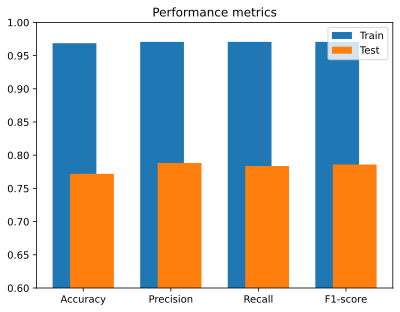

In [ ]:
plt.bar(np.arange(4) - .1, train_metrics, .5)
plt.bar(np.arange(4) + .1, test_metrics, .5)
plt.xticks([0, 1, 2, 3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.6, 1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')
plt.show()

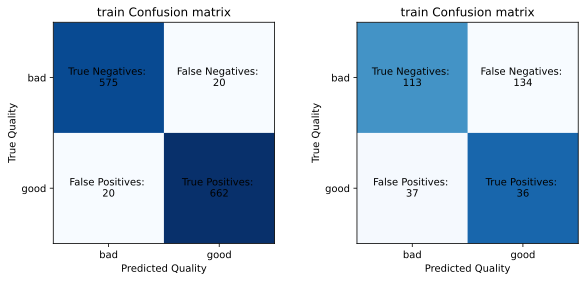

In [ ]:
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions > 0)
testConf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions > 0)

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

# confmat during train
ax[0].imshow(trainConf, 'Blues', vmax = len(train_predictions)/2)
ax[0].set_yticks([0,1])
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['bad', 'good'])
ax[0].set_yticklabels(['bad', 'good'])
ax[0].set_xlabel('Predicted Quality')
ax[0].set_ylabel('True Quality')
ax[0].set_title('train Confusion matrix')

# add text labels
ax[0].text(0,0,f'True Negatives: \n{trainConf[0,0]}', ha = 'center', va = 'center')
ax[0].text(0,1,f'False Positives: \n{trainConf[0,1]}', ha = 'center', va = 'center')
ax[0].text(1,0,f'False Negatives: \n{trainConf[1,0]}', ha = 'center', va = 'center')
ax[0].text(1,1,f'True Positives: \n{trainConf[1,1]}', ha = 'center', va = 'center')

# confmat furing test
ax[1].imshow(testConf, 'Blues', vmax = len(test_predictions)/2)
ax[1].set_yticks([0,1])
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['bad', 'good'])
ax[1].set_yticklabels(['bad', 'good'])
ax[1].set_xlabel('Predicted Quality')
ax[1].set_ylabel('True Quality')
ax[1].set_title('train Confusion matrix')

# add text labels
ax[1].text(0,0,f'True Negatives: \n{testConf[0,0]}', ha = 'center', va = 'center')
ax[1].text(0,1,f'False Positives: \n{testConf[1,0]}', ha = 'center', va = 'center')
ax[1].text(1,0,f'False Negatives: \n{testConf[1,1]}', ha = 'center', va = 'center')
ax[1].text(1,1,f'True Positives: \n{testConf[0,1]}', ha = 'center', va = 'center')

plt.show()

In [ ]:
trainConf

array([[575,  20],
       [ 20, 662]])